In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 18,
        'serif'  : 'New Century Schoolbook'}
rc('font', **font)
import numpy as np

In [2]:
from pyke import SimpleKeplerPRF, PRFPhotometry, SceneModel
from pyke.lightcurve import KeplerLightCurveFile, LightCurve
from pyke import KeplerTargetPixelFile
from pyke.utils import KeplerQualityFlags
from oktopus import UniformPrior

/Users/jvmirca/dev/PyKE/pyke/__init__.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.insta

In [3]:
tpf = KeplerTargetPixelFile("https://archive.stsci.edu/missions/k2/target_pixel_files/c91/"
                            "224400000/32000/ktwo224432562-c91_lpd-targ.fits.gz",
                            quality_bitmask=2096639)

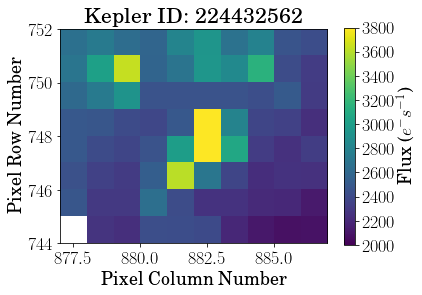

In [4]:
tpf.plot(frame=1, vmin=2000, vmax=3800)
#plt.savefig('tpf_c9.eps', transparent=True, bbox_inches='tight', pad_inches=.1)

In [5]:
prf = tpf.get_prf_model()

In [6]:
scene = SceneModel(prfs=5*[prf])

In [7]:
# define priors for flux, column, row
prior = UniformPrior(lb=[1e2, 880, 745, 1e2, 881, 746, 1e2, 878, 749, 1e2, 883.5, 749, 1e2, 881, 749, 0],
                     ub=[5e3, 883, 748, 12e3, 884, 750, 5e3, 881, 752, 5e3, 886, 752, 5e3, 884, 752, 4.6e3])

Text(0.5,1,'PSF Models')

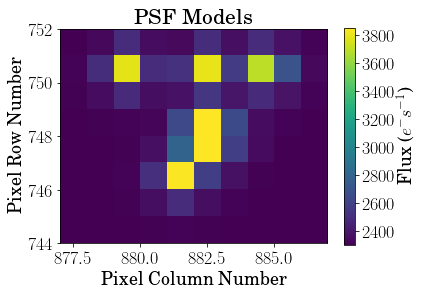

In [8]:
scene.plot(*prior.mean)
plt.title('PSF Models')

In [9]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [10]:
results = phot.fit(tpf.flux, options={'ftol':1e-12, 'xtol':1e-6, 'maxfev':2000})

  0%|          | 0/1205 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  4%|▎         | 43/1205 [00:32<14:44,  1.31it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
100%|██████████| 1205/1205 [16:07<00:00,  1.25it/s]


In [11]:
residuals = phot.get_residuals()

In [12]:
flux1 = results[:, 0]
xc1 = results[:, 1]
yc1 = results[:, 2]
flux2 = results[:, 3]
xc2 = results[:, 4]
yc2 = results[:, 5]
flux3 = results[:, 6]
xc3 = results[:, 7]
yc3 = results[:, 8]
flux4 = results[:, 9]
xc4 = results[:, 10]
yc4 = results[:, 11]
flux5 = results[:, 12]
xc5 = results[:, 13]
yc5 = results[:, 14]
bkg = results[:, -1]

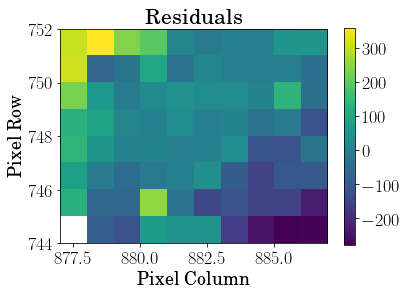

In [14]:
plt.imshow(residuals[0], origin='lower', extent=(877, 887, 744, 752))
plt.title("Residuals")
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
cbar = plt.colorbar()
cbar.ax.set_label(r"Flux $(e^{-}s^{-1})$")
#plt.savefig('residuals_c9.eps', transparent=True, bbox_inches='tight', pad_inches=.1)

In [15]:
from pyke.lightcurve import KeplerLightCurve

In [16]:
klc = KeplerLightCurve(time=tpf.time, flux=flux2, centroid_col=xc2, centroid_row=yc2)

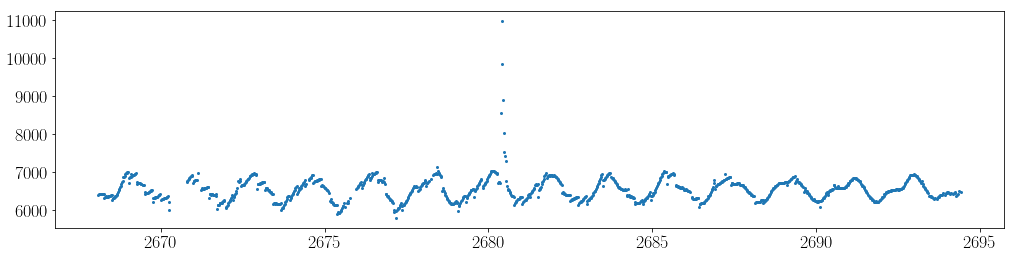

In [19]:
plt.figure(figsize=[17, 4])
plt.plot(klc.time, klc.flux, 'o', markersize=2)

In [25]:
flat_lc, trend_lc = klc.flatten(window_length=31, return_trend=True)

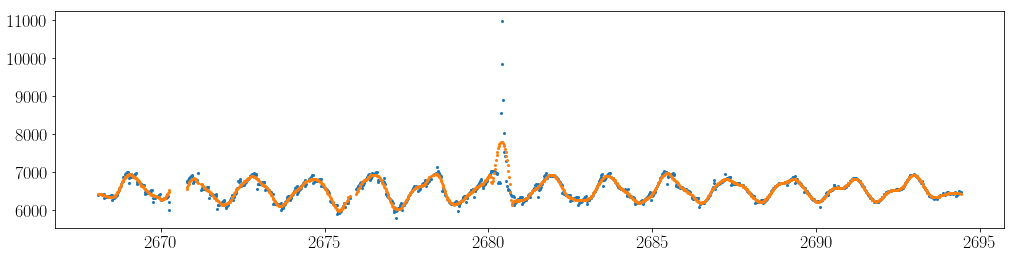

In [26]:
plt.figure(figsize=[17, 4])
plt.plot(klc.time, klc.flux, 'o', markersize=2)
plt.plot(trend_lc.time, trend_lc.flux, 'o', markersize=2)

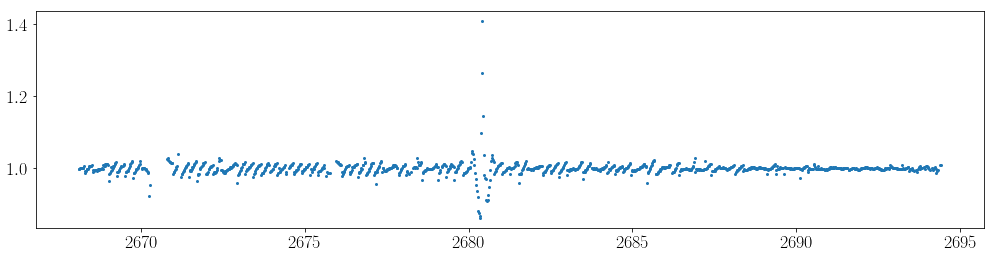

In [27]:
plt.figure(figsize=[17, 4])
plt.plot(flat_lc.time, flat_lc.flux, 'o', markersize=2)

In [53]:
sff_lc = flat_lc.correct(niters=10, windows=7)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 14%|█▍        | 1/7 [00:00<00:00,  8.93it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 29%|██▊       | 2/7 [00:00<00:00,  8.84it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 43%|████▎     | 3/7 [00:00<00:00,  8.76it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 57%|█████▋    | 4/7 [00:00<00:00,  8.78it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 71%|███████▏  | 5/7 [00:00<00:00,  8.83it/s]/Users/jvmirca/dev/PyKE/pyke

In [54]:
sff = sff_lc.corrector

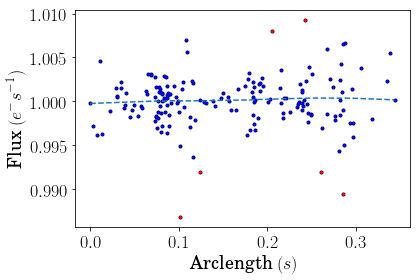

In [55]:
sff._plot_normflux_arclength()

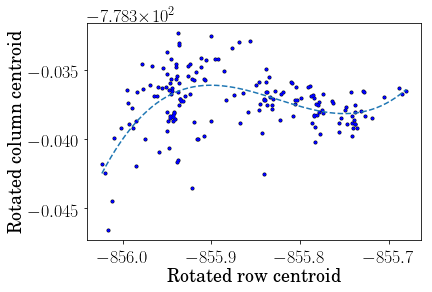

In [56]:
sff._plot_rotated_centroids()

(6000, 8000)

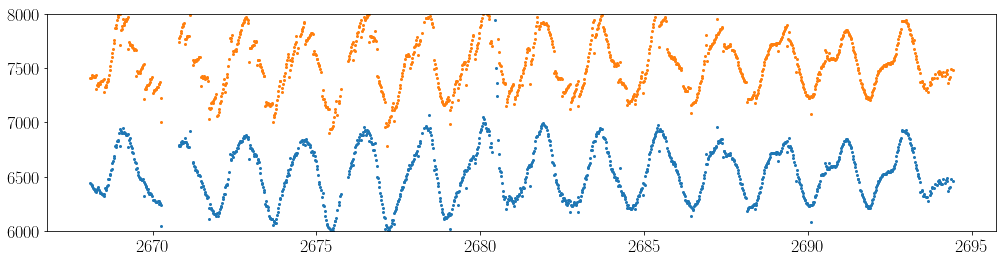

In [64]:
plt.figure(figsize=[17, 4])
plt.plot(sff_lc.time, sff_lc.flux*trend_lc.flux, 'o', markersize=2)
plt.plot(klc.time, klc.flux+1000, 'o', markersize=2)
plt.ylim(6000, 8000)

In [67]:
klc = KeplerLightCurve(time=tpf.time, flux=flux1, centroid_col=xc1, centroid_row=yc1)

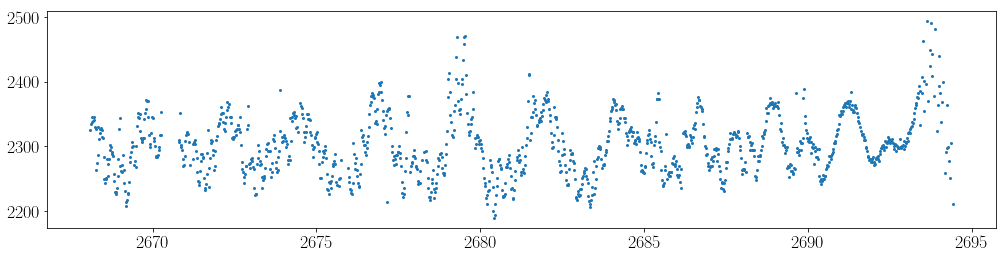

In [68]:
plt.figure(figsize=[17, 4])
plt.plot(klc.time, klc.flux, 'o', markersize=2)

In [69]:
flat_lc, trend_lc = klc.flatten(window_length=31, return_trend=True)

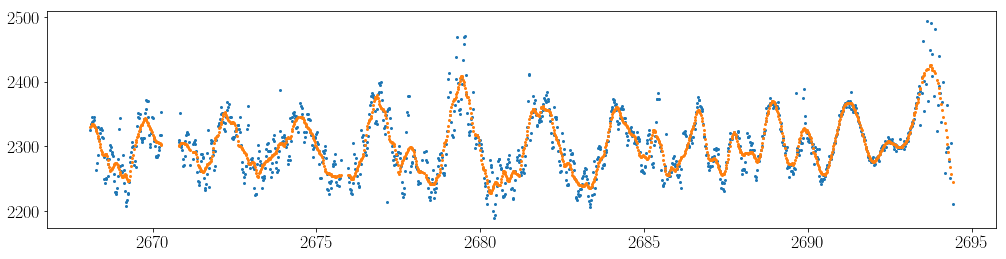

In [70]:
plt.figure(figsize=[17, 4])
plt.plot(klc.time, klc.flux, 'o', markersize=2)
plt.plot(trend_lc.time, trend_lc.flux, 'o', markersize=2)

In [87]:
sff_lc = flat_lc.correct(niters=10, windows=7, sigma_1=5.0, sigma_2=5.0, bins=30)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 14%|█▍        | 1/7 [00:00<00:00,  8.17it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 29%|██▊       | 2/7 [00:00<00:00,  8.14it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 43%|████▎     | 3/7 [00:00<00:00,  8.34it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 57%|█████▋    | 4/7 [00:00<00:00,  8.20it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 71%|███████▏  | 5/7 [00:00<00:00,  8.12it/s]/Users/jvmirca/dev/PyKE/pyke

In [88]:
sff = sff_lc.corrector

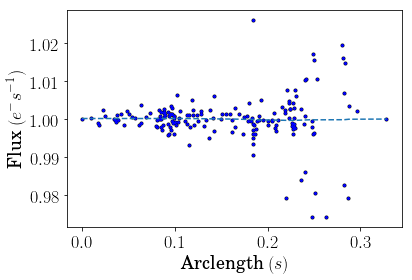

In [89]:
sff._plot_normflux_arclength()

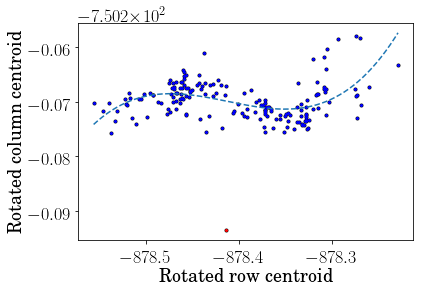

In [90]:
sff._plot_rotated_centroids()

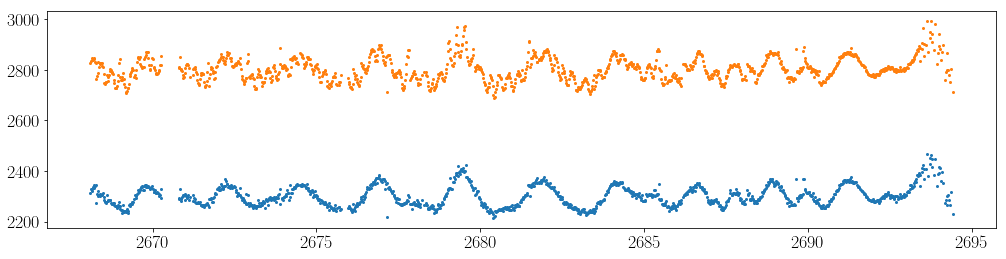

In [91]:
plt.figure(figsize=[17, 4])
plt.plot(sff_lc.time, sff_lc.flux*trend_lc.flux, 'o', markersize=2)
plt.plot(klc.time, klc.flux+500, 'o', markersize=2)

In [92]:
klc = KeplerLightCurve(time=tpf.time, flux=flux3, centroid_col=xc3, centroid_row=yc3)

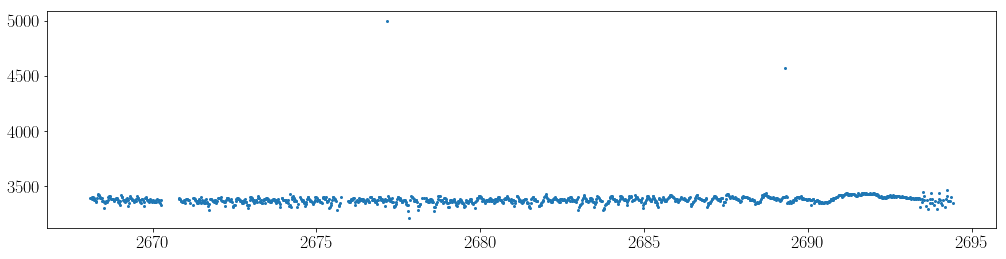

In [95]:
plt.figure(figsize=[17, 4])
plt.plot(klc.time, klc.flux, 'o', markersize=2)

In [125]:
sff_lc = klc.correct(niters=10, windows=2, bins=20)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:597: RankWarning: Polyfit may be poorly conditioned
  self.rot_col[~self.outlier_cent], polyorder)
100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


(0.95, 1.02)

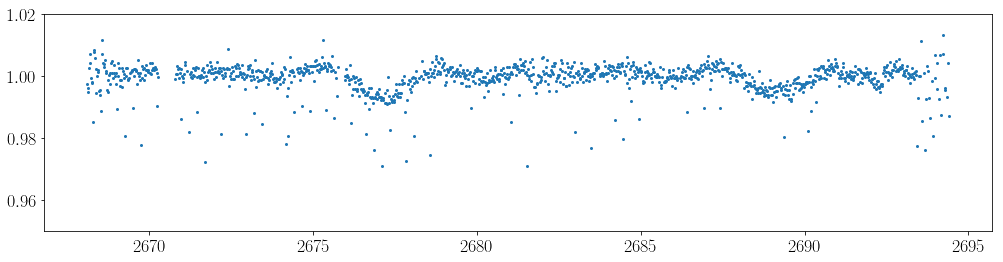

In [126]:
plt.figure(figsize=[17, 4])
#plt.plot(klc.time, klc.flux, 'o', markersize=2)
plt.plot(sff_lc.time, sff_lc.flux, 'o', markersize=2)
plt.ylim(.95, 1.02)

In [122]:
sff = sff_lc.corrector

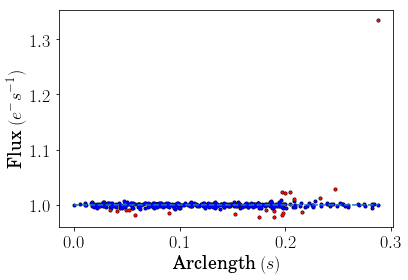

In [123]:
sff._plot_normflux_arclength()

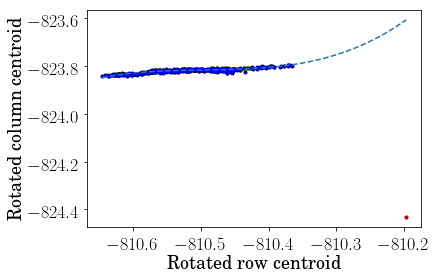

In [124]:
sff._plot_rotated_centroids()

In [128]:
tpf = KeplerTargetPixelFile("../../aas/k2_clusters/campaign9/ktwo224432562-c92_lpd-targ.fits.gz",
                            quality_bitmask=2096639)

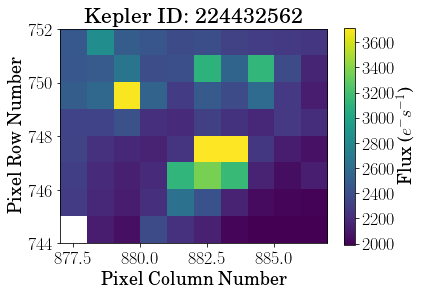

In [131]:
tpf.plot()

In [150]:
# define priors for flux, column, row
prior = UniformPrior(lb=[1e2, 880, 745, 1e2, 881, 746, 0],
                     ub=[3e3, 885, 748, 12e3, 885, 749, 2.5e3])

In [151]:
prf = tpf.get_prf_model()

In [152]:
scene = SceneModel(prfs=2*[prf])

Text(0.5,1,'PSF Models')

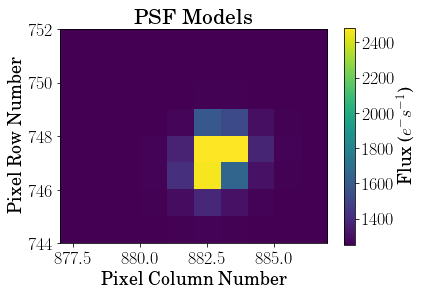

In [153]:
scene.plot(*prior.mean)
plt.title('PSF Models')

In [154]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [155]:
results = phot.fit(tpf.flux, options={'ftol':1e-12, 'xtol':1e-6, 'maxfev':2000})

  0%|          | 0/1962 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  5%|▌         | 100/1962 [00:30<09:31,  3.26it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
100%|██████████| 1962/1962 [10:47<00:00,  3.03it/s]


In [156]:
flux1 = results[:, 0]
xc1 = results[:, 1]
yc1 = results[:, 2]
flux2 = results[:, 3]
xc2 = results[:, 4]
yc2 = results[:, 5]
bkg = results[:, -1]

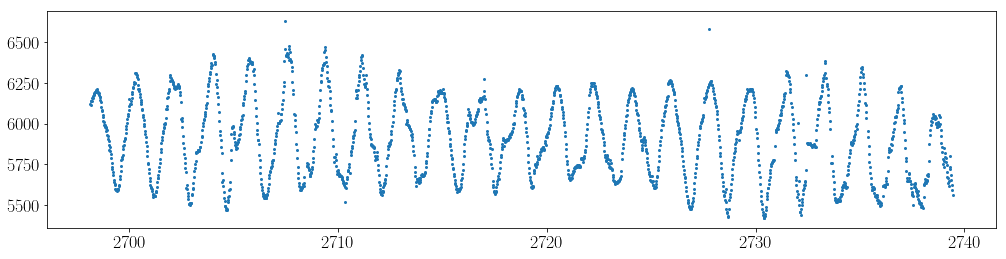

In [158]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux2, 'o', markersize=2)

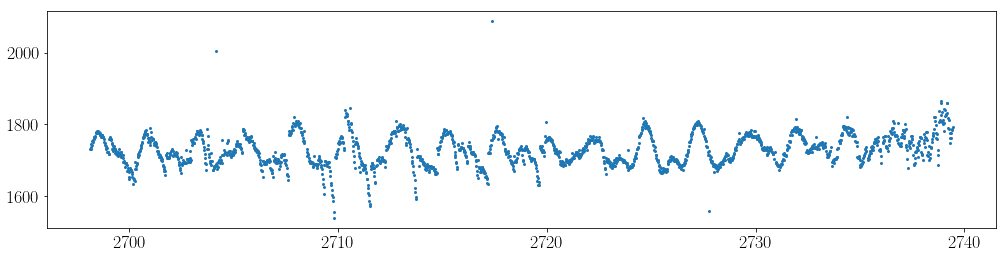

In [159]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux1, 'o', markersize=2)

In [160]:
residuals = phot.get_residuals()

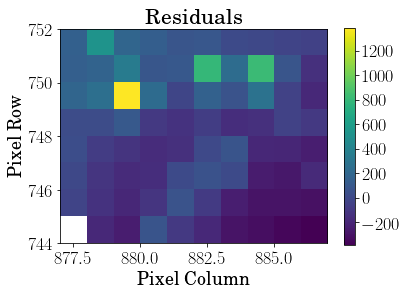

In [161]:
plt.imshow(residuals[0], origin='lower', extent=(877, 887, 744, 752))
plt.title("Residuals")
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
cbar = plt.colorbar()
cbar.ax.set_label(r"Flux $(e^{-}s^{-1})$")